# Exercie sur dataset EEG 

40 min

Approche simple d'un dataset EEG en 4 étapes:

  * Ouvrir un fichier : signaux/triggers
  * filtrer les signaux
  * se créer un viewer

  * faire des ERP : moyenne des signaux autour des triggers (évenements) en fonction des labels du trigger




# Etape 1: lecture des datas

  * Installer un module python qui commence par **n**  et qui finit par **o**
  * Ouvrir le fichier **File_micromed_1.TRC** acquis via un système micromed.
  * Avec matplotlib afficher vite fait quelques channels sur quelques secondes + triggers
  



# Solution étape 1

In [1]:
import neo
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
filename = './data/File_micromed_1.TRC'
reader = neo.MicromedIO(filename=filename)
print(reader)

#bl = reader.read_block()
#print('nb segment', len(bl.segments))
#seg = bl.segments[0]  # Ici, un seul segment (un seul enregistrement)

seg = reader.read_segment()
print('seg : ', seg)
#seg = reader.read_segment(signal_group_mode='split-all')
#print('seg : ', seg)
#seg = reader.read_segment(signal_group_mode='group-by-same-units')

print('*'*10)
print('signals')
for anasig in seg.analogsignals:
    print('    ',anasig.name, anasig.shape, anasig.units, anasig.annotations)
    
print('*'*10)
print('events')
for ev in seg.events:
    print('   ', ev.name, ev.times, ev.labels)

print('*'*10)
print('epochs')
for ep in seg.epochs:
    print('   ', ep.name, ep.times, ep.durations.shape, np.unique(ev.labels))

MicromedIO: ./data/File_micromed_1.TRC
nb_block: 1
nb_segment:  [1]
signal_streams: [Signals (chans: 64)]
signal_channels: [FP1, FP2, AF7, AF3 ... Trig , VEOG , HEOG , EMG]
spike_channels: []
event_channels: [Trigger, Note, Event A, Event B]

seg :  <neo.core.segment.Segment object at 0x771df8ad95a0>
**********
signals
     Signals (1000, 64) 1.0 uV {'stream_id': '0'}
**********
events
    Trigger [0.203125   1.12890625 2.02734375 3.82421875] s ['1' '1' '1' '1']
    Note [] s []
**********
epochs
    Event A [] s (0,) []
    Event B [] s (0,) []


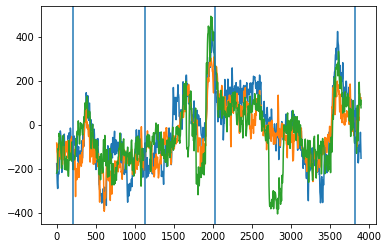

In [4]:
fig, ax = plt.subplots()

for chan in [0, 15, 50]:
    ax.plot(anasig.times.rescale('ms'), anasig[:, chan].magnitude)

for t in seg.events[0].times:
    ax.axvline(t.rescale('ms'))

label 1 nb 4
label 2 nb 0


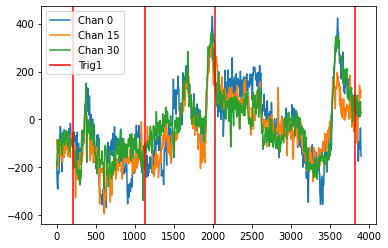

In [5]:
#anasig = seg.analogsignals[0]
triggers = seg.events[0]

# Plot de 3 cannaux :
channels = [0, 15, 20]

fig, ax = plt.subplots()
ax.plot(anasig.times.rescale('ms'), anasig[:, channels].magnitude)

# Ajout des triggers
labels = ['1', '2']             #Si on avait plusieurs triggers différents.. (pas le cas ici)
colors = {'1':'r', '2':'b'}

for label in labels:
    sel = triggers.labels == label
    print('label', label, 'nb', np.sum(sel))
    times = triggers.times[sel].rescale('ms')
    for t in times:
        ax.axvline(t.rescale('ms'), color=colors[label])

ax.legend(['Chan 0', 'Chan 15', 'Chan 30', 'Trig1'], loc='best')
#ax.set_xlim(2., 3.)

# Etape 2: spectre et filtrage des signaux

Il y a un comme d'hab du 50Hz.

Avec scipy.signal:

  * afficher les spectres
  * filtrer les siganux entre 0.5 - 49 Hz
  
Tips:
 
   * Attention scipy.signal.filtfilt plutôt que lfilter
   

# solution étape 2

fe :  256.0


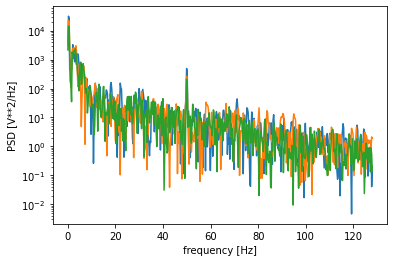

truc


In [6]:
## Tracé du spectre

import scipy.signal
channels = [0, 15, 20]

# Revenenir vers du int/numpy avec la bonne unité
fe = anasig.sampling_rate.rescale('Hz').magnitude
print('fe : ', fe)
sigs = anasig.rescale('uV').magnitude 

fig, ax = plt.subplots()
for chan in channels:
    sig = sigs[:, chan]
    freqs, Pxx_den = scipy.signal.welch(sig, fs=fe, nperseg=1000)
    ax.semilogy(freqs, Pxx_den)

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
#ax.set_xlim(0, 100.)
#ax.set_ylim(1, 10000.)
plt.show()
print('truc')

(8, 6)


Text(0, 0.5, 'PSD [V**2/Hz]')

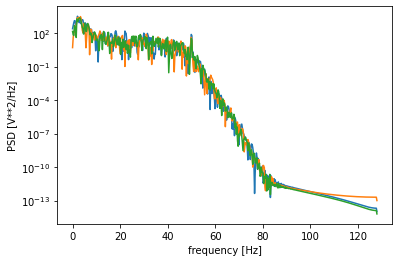

In [7]:
# Filtre du signal et plot du spectre du signal filtré

f1, f2 = 0.5, 49
band = [f1/fe*2., f2/fe*2.]

# ici filtrage avec SOS = filtrage biquad (-> execution en cascade)
coeff_sos = scipy.signal.iirfilter(8, band, analog=False,
                        btype='bandpass', ftype='butter', output='sos')
print(coeff_sos.shape)

# on filtre tous les canaux d'un seul coup avec sosfiltfilt + axis !
filtered_sigs = scipy.signal.sosfiltfilt(coeff_sos, sigs, axis=0)

# Tracé des spectres
fig, ax = plt.subplots()
for chan in channels:
    filtered_sig = filtered_sigs[:, chan]
    freqs, Pxx_den = scipy.signal.welch(filtered_sig, fs=fe, nperseg=1000)
    ax.semilogy(freqs, Pxx_den)

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
#ax.set_xlim(0, 100.)
#ax.set_ylim(1, 10000.)

# Etape 3: créer un *viewer custum*

  * avec ephyviewer se créer un viewer pour se balader dans les signaux avec:
    * les signaux
    * les signaux filtrés
    * les cartes temps fréquences
    * les triggers en liste


# Solution

In [8]:
%gui qt5
from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer
from ephyviewer import InMemoryEpochSource, EpochViewer, EventList
import numpy as np
import neo
import scipy.signal

#Import des signaux
filename = './data/File_micromed_1.TRC'
reader = neo.MicromedIO(filename=filename)

seg = reader.read_segment()
anasig = seg.analogsignals[0]
triggers = seg.events[0]


# signaux + signaux filtrés
sr = anasig.sampling_rate.rescale('Hz').magnitude
t_start = anasig.t_start.rescale('s').magnitude
print('sr', sr, 't_start', t_start)
f1, f2 = 5, 49
band = [f1/sr*2., f2/sr*2.]
sigs = anasig.rescale('uV').magnitude

coeff_sos = scipy.signal.iirfilter(8, band, analog=False,
                        btype='bandpass', ftype='butter', output='sos')
filtered_sigs = scipy.signal.sosfiltfilt(coeff_sos, sigs, axis=0)

# main wibndow + QApp
app = mkQApp()
win = MainViewer()

# view1 = signaux
view1 = TraceViewer.from_numpy(sigs, sr, t_start, 'Signals')
win.add_view(view1)

# view2 = signaux filtrés
view2 = TraceViewer.from_numpy(filtered_sigs, sr, t_start, 'Filtered Signals')
win.add_view(view2)

# view3 = temps fréquences
view3 = TimeFreqViewer.from_numpy(sigs, sr, t_start, 'tfr') #timefreq
win.add_view(view3)

# data source commune à viewer4 et viewer5
epoch = { 'time':triggers.times.rescale('s').magnitude,
                'duration': np.zeros(triggers.times.size),
                'label':triggers.labels,
                'name':'triggers' }
data_source_epoch = InMemoryEpochSource(all_epochs=[epoch])

# view4 = triggers
view4 = EpochViewer(source=data_source_epoch, name='triggers')
win.add_view(view4)

# view5 = list triggers
view5 = EventList(source=data_source_epoch, name='triggers list')
win.add_view(view5, location='bottom',  orientation='horizontal')


#Run
win.show()
app.exec_()

sr 256.0 t_start 0.0


QSocketNotifier: Can only be used with threads started with QThread


ValueError: '' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

# Etape 4 : moyenne des ERP par condition

Pour les channels [0,15,20,22] à partir des signaux filtrés:

  * empiler les ERP dans une fenêtre -200ms, 1000ms, pour les trois premiers triggers
  * faire la moyenne


sr 256.0 t_start 0.0
[0.203125   1.12890625 2.02734375]
nb_samples :  204.8
(1000, 64)
signal.shape :  (308, 4)
signal.shape :  (308, 4)
signal.shape :  (308, 4)
(3, 308, 4)
(308, 4)


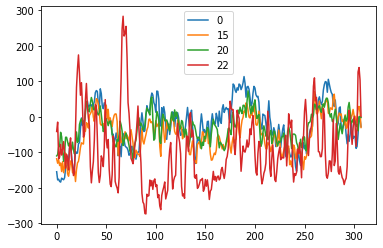

In [15]:

import numpy as np
import neo
import scipy.signal

#Import des signaux
filename = './data/File_micromed_1.TRC'
reader = neo.MicromedIO(filename=filename)

seg = reader.read_segment()
anasig = seg.analogsignals[0]
triggers = seg.events[0]

# signaux + signaux filtrés
sr = anasig.sampling_rate.rescale('Hz').magnitude
t_start = anasig.t_start.rescale('s').magnitude
print('sr', sr, 't_start', t_start)
f1, f2 = 5, 49
band = [f1/sr*2., f2/sr*2.]
sigs = anasig.rescale('uV').magnitude

coeff_sos = scipy.signal.iirfilter(8, band, analog=False,
                        btype='bandpass', ftype='butter', output='sos')
filtered_sigs = scipy.signal.sosfiltfilt(coeff_sos, sigs, axis=0)


# ERP
chans = [0, 15, 20, 22]
times = [-0.2, 1] # 1,2s x sr (256) = 307,2 donc 308 samples
trigs = seg.events[0].times.rescale('s').magnitude[0:3]
print(trigs)

nb_chans = len(chans)
nb_samples = (times[0] + times[1]) * sr
print('nb_samples : ', nb_samples)
ERP = []

print(sigs.shape)
for tt in trigs:
    sample_start = int((tt + times[0]) * sr)
    sample_stop = int((tt + times[1]) * sr)
    signal = sigs[sample_start:sample_stop, chans]  #308 samples x 4 canaux
    print('signal.shape : ', signal.shape )
    ERP.append(signal)
    
#print(ERP)  # liste [[308x3][308x3][308x3]]
ERP_arr = np.asarray(ERP)
print(ERP_arr.shape)  # 3 trigs, 308 samples, 4 canaux

# PE (moyenne des ERP)
mean_ERP = np.mean(ERP_arr, axis = 0) 
print(mean_ERP.shape)

# Plot
fig, ax = plt.subplots()
ax.plot(mean_ERP)
ax.legend([str(chan) for chan in chans], loc='best')


# Mais en VRAI, utilisez Python MNE pour faire de l'EEG !

https://martinos.org/mne/stable/index.html
+
lien Neo-MNE en cours 
https://gist.github.com/agramfort/7fc27a18fcdc0e8cff3f
...